In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error,log_loss
from sklearn.model_selection import KFold
import lightgbm as lgb
from tqdm import tqdm_notebook
import geopandas as gpd

import warnings
warnings.filterwarnings("ignore")

In [2]:
DATA_FOLDER = './input_files/'
OUTPUT_PATH = './output_files/model_2_partial_terra.csv'
df = pd.read_csv(DATA_FOLDER + "Train.csv")
sub_df = pd.read_csv(DATA_FOLDER + "SampleSubmission.csv")
wetlands = pd.read_csv(DATA_FOLDER + 'wetlands.csv')
TerraClimateDataTrain = pd.read_csv('../ExternalData/TerraClimateDataTrain.csv')#https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
TerraClimateDataTest = pd.read_csv('../ExternalData/TerraClimateDataTest.csv')#https://developers.google.com/earth-engine/datasets/catalog/IDAHO_EPSCOR_TERRACLIMATE
TerraClimateDataTrain = TerraClimateDataTrain[['vap1yearbefore_month_2','vap2yearsbefore_month_1','vap2yearsbefore_month_3','vap2yearsbefore_month_4','vap2yearsbefore_month_6','vap1yearbefore_month_1','vap1yearbefore_month_5','X','Y']]
TerraClimateDataTest  = TerraClimateDataTest[['vap1yearbefore_month_2','vap2yearsbefore_month_1','vap2yearsbefore_month_3','vap2yearsbefore_month_4','vap2yearsbefore_month_6','vap1yearbefore_month_1','vap1yearbefore_month_5','X','Y']]

In [3]:
precip_cols = [c for c in df.columns if 'precip' in c]
len(precip_cols), len(precip_cols)//2

(34, 17)

In [4]:
precip_cols_2015 = precip_cols[0: 17]
precip_cols_2019 = precip_cols[17: 34]
train = df[precip_cols_2015]
train.columns = [f'precip_week_{i}' for i in range(1, 18)]
test = df[precip_cols_2019]
test.columns = [f'precip_week_{i}' for i in range(1, 18)]
train = pd.concat([train, df[['X', 'Y', 'target_2015', 'elevation', 'LC_Type1_mode', 'Square_ID']]], axis=1)
test = pd.concat([test, df[['X', 'Y', 'target_2015', 'elevation', 'LC_Type1_mode', 'Square_ID']]], axis=1)

In [5]:
train = train.merge(TerraClimateDataTrain,how="left",on=['X','Y'])
test = test.merge(TerraClimateDataTest,how="left",on=['X','Y'])

In [6]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.X, df.Y, df.elevation))

In [7]:
df = pd.concat([train, test]).reset_index(drop=True)
df.shape

(32932, 30)

In [8]:
precip_cols = [c for c in df.columns if 'precip' in c]
len(precip_cols)
print(precip_cols)

['precip_week_1', 'precip_week_2', 'precip_week_3', 'precip_week_4', 'precip_week_5', 'precip_week_6', 'precip_week_7', 'precip_week_8', 'precip_week_9', 'precip_week_10', 'precip_week_11', 'precip_week_12', 'precip_week_13', 'precip_week_14', 'precip_week_15', 'precip_week_16', 'precip_week_17']


In [9]:
def add_diff_interacts(df, inter_cols):
    '''
    This function calucates all possible combinations of differences for columns provided to into pairs for the given dataframe.
    For example: If we have columns: Col_1, Col_2, Col_3 then it will calculate Col_1 - Col_2, Col_1 - Col_3, Col_2 - Col_3
    This is to calculate the differnce in precipitation between different weeks of rainfall, like the difference in rainfall between week 17 and week 16.
    
    df: DataFrame
    inter_cols: The columns for which the difference needs to be computed
    
    returns: New dataframe with the difference columns added to it.
    '''
    def apply_interacts(x, inter_cols):
        cols = [x + '_diff_' + c for c in inter_cols[inter_cols.index(x)+1:]]
        interacts_df[cols] = pd.concat([df[x] - df[c] for c in inter_cols[inter_cols.index(x)+1:]], axis=1)
    
    interacts_df = pd.DataFrame()
    _ = df[inter_cols[:-1]].apply(lambda x: apply_interacts(x.name, inter_cols))
    df = pd.concat([df, interacts_df], axis=1)

    return df
df = add_diff_interacts(df, precip_cols)

step = 0.2
to_bin = lambda x: np.floor(x / step) * step
df["latbin"] = df.X.map(to_bin)
df["lonbin"] = df.Y.map(to_bin)

df['prev_x'] = df['X'] - 0.01
df['next_x'] = df['X'] + 0.01
df['prev_y'] = df['Y'] - 0.01
df['next_y'] = df['Y'] + 0.01

### Divide into 2 regions, low elevation and high elevation
df['elevation_cut'] = pd.cut(pd.Series(np.sqrt(df['elevation'])), 2, labels=False)

In [10]:
train = df[:train.shape[0]].reset_index(drop=True)
test = df[train.shape[0]:].reset_index(drop=True)

In [11]:
features = [c for c in train.columns if c not in ['Square_ID','target_2015', 'geometry'] + precip_cols]

In [12]:
param = {'num_leaves': 186,
     'min_data_in_leaf': 40, 
     'objective':'regression',
     'max_depth': -1,
     'learning_rate': 0.15,
     "boosting": "gbdt",
     "feature_fraction": 0.7,
     "bagging_seed": 4,
     "metric": 'rmse',
     "lambda_l1": 1,
     "lambda_l2": 1,
    }

In [13]:
features = [c for c in train.columns if c not in ['Square_ID','target_2015', 'geometry'] + precip_cols]
print(len(features))
target = train['target_2015']

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

#### Our chosen hyperparameters were under-predicting the floods in some sense, the maximum flooding was around 0.8xx
#### To remedy this underprediction we chose an arbitary number greater than one, i.e, 1.02, so our maximum flooding crossed 0.9
#### Choosing a multiplier only changes the non-zero values.
#### The '0' values or areas with no flood will not be affected as 0 x 1.02 = 0 still.
#### Different multipliers have been used in different notebooks so the resultant blend will give a greater boost

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx]*1.02)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx]*1.02)

    num_round = 1500
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    tmp = clf.predict(test[features], num_iteration=clf.best_iteration)

oof_lgb[oof_lgb < 0] = 0
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb, target)**0.5))
pt_1 = predictions_lgb

154
fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.0800742	valid_1's rmse: 0.102122
[200]	training's rmse: 0.0761674	valid_1's rmse: 0.101002
[300]	training's rmse: 0.0761674	valid_1's rmse: 0.101002
Early stopping, best iteration is:
[184]	training's rmse: 0.0762126	valid_1's rmse: 0.100986
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.0804846	valid_1's rmse: 0.101322
[200]	training's rmse: 0.0761875	valid_1's rmse: 0.0997518
[300]	training's rmse: 0.0761875	valid_1's rmse: 0.0997518
Early stopping, best iteration is:
[193]	training's rmse: 0.0761886	valid_1's rmse: 0.0997516
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.0820178	valid_1's rmse: 0.0953389
[200]	training's rmse: 0.0772191	valid_1's rmse: 0.0939287
[300]	training's rmse: 0.0772191	valid_1's rmse: 0.0939287
Early stopping, best iteration is:
[193]	training's rmse: 0.077282

In [14]:
features = [c for c in train.columns if c not in ['Square_ID','target_2015', 'geometry'] + precip_cols]
print(len(features))
target = train['target_2015']

folds = KFold(n_splits=5, shuffle=True, random_state=15)
oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros(len(test))
feature_importance_df = pd.DataFrame()

for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, target.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=target.iloc[trn_idx]*1)
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=target.iloc[val_idx]*1)

    num_round = 1500
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=100, early_stopping_rounds = 200)
    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)

    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"] = features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

    predictions_lgb += clf.predict(test[features], num_iteration=clf.best_iteration) / folds.n_splits
    tmp = clf.predict(test[features], num_iteration=clf.best_iteration)

oof_lgb[oof_lgb < 0] = 0
print("CV score: {:<8.5f}".format(mean_squared_error(oof_lgb*0.9, target)**0.5))

#### Our chosen hyperparameters were under-predicting the floods in some sense, the maximum flooding was around 0.8xx
#### To remedy this underprediction we chose an arbitary number greater than one, i.e, 1.03, so our maximum flooding crossed 0.9
#### Choosing a multiplier only changes the non-zero values.
#### The '0' values or areas with no flood will not be affected as 0 x 1.03 = 0 still.
#### This is different than the previous case, because here we multiply the final predictions by 1.03, whereas previously we multiplied our target by 1.03
pt_2 = predictions_lgb*1.03

154
fold n°0
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.0791416	valid_1's rmse: 0.100252
[200]	training's rmse: 0.0753648	valid_1's rmse: 0.0990191
[300]	training's rmse: 0.0753648	valid_1's rmse: 0.0990191
Early stopping, best iteration is:
[166]	training's rmse: 0.0753673	valid_1's rmse: 0.0990187
fold n°1
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.0795034	valid_1's rmse: 0.0991606
[200]	training's rmse: 0.0751728	valid_1's rmse: 0.0976238
[300]	training's rmse: 0.0751728	valid_1's rmse: 0.0976238
Early stopping, best iteration is:
[194]	training's rmse: 0.0751728	valid_1's rmse: 0.0976238
fold n°2
Training until validation scores don't improve for 200 rounds.
[100]	training's rmse: 0.0808237	valid_1's rmse: 0.0936924
[200]	training's rmse: 0.0757707	valid_1's rmse: 0.0924087
[300]	training's rmse: 0.0757662	valid_1's rmse: 0.0924074
[400]	training's rmse: 0.0757662	valid_1's rmse: 0.0924074
Ear

In [15]:
predictions_lgb = pt_1 * 0.75 + pt_2 * 0.25

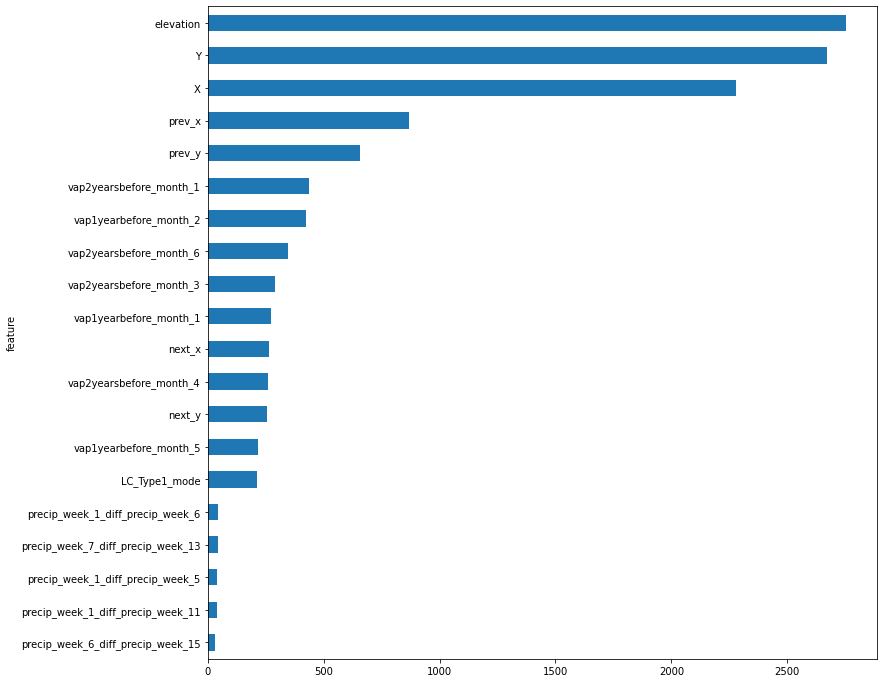

In [16]:
plt.figure(figsize=(12, 12))
fi = feature_importance_df.groupby('feature')['importance'].mean()
fi.sort_values()[-20:].plot.barh()

In [17]:
predictions_lgb[predictions_lgb < 0.2] = 0
predictions_lgb[predictions_lgb > 1] = 1
np.corrcoef(target, predictions_lgb)

array([[1.        , 0.70959671],
       [0.70959671, 1.        ]])

In [18]:
def rectify_submission(best_sub):
    
    '''
    This function is used to rectify the submissions based on EDA, and external data. 
    The documentation for the function can be found at: " "
    wetlands: Gives the wetland distance of the place. The data source used is " ", and is described at: " "
    
    '''
    
    train['wetland_dist'] = wetlands['wetland_dist']
    target = train['target_2015']
    gdf = gpd.GeoDataFrame(
        train, geometry=gpd.points_from_xy(train.X, train.Y))
    gdf['target_2015'] = target
    gdf['best_sub'] =  best_sub
    best_sub_2 = best_sub.copy()
    
    #### Rectifications based on wetland distance. Places very near the wetlands are more likely to get flooded and vice versa.
    #### The magnitues are in metres, So 5000 metres = 5 kilometres and 10000 metres = 10 kilometres
    
    sel = (best_sub_2 == 0)
    best_sub_2[sel] = 0.02
    sel = (train['wetland_dist'] > 5000) & (train['wetland_dist'] <= 10000)
    best_sub_2[sel] = 0.01
    sel = (train['wetland_dist'] > 10000)
    best_sub_2[sel] = 0
    sel = (train['wetland_dist'] == 0) & (train['target_2015'] == 1) & (train['elevation'] < 55)
    best_sub_2[sel] = 0.95
    
    #### These regions are neither unflooded nor too much flooded, we blend them with the floods of 2015, by a very small amount to get a small boost
    
    sel = (best_sub_2 > 0.1) & (best_sub_2 < 0.9)
    best_sub_2[sel] = best_sub_2[sel] * 0.87 + train['target_2015'][sel] * 0.13
    
    sel = (train['wetland_dist'] == 0) & (best_sub < 0.9)
    print(sel.sum())
    best_sub_2[sel] *= 1.02
    
    ### The lower part of the map is mostly flooded, so we increase the flooding of the unflooded regions by a small percen (5 %).
    ### This is again an arbitary number, and can further be tuned further
    
    ### The eastern hemisphere is almost completely not flooded in our 2019 predictions, and we only see a negligibly small spot flooded.
    ### To get rid of it, we set the flooding of the entire eastern region to 0.
    
    sel = (best_sub_2 > 0) & (best_sub_2 < 0.03) & (train.Y < 16.0)
    print(sel.sum())
    best_sub_2[sel] *= 1.05
    
    gdf['rectified'] = best_sub_2
    sel = (train.X >= 35.3) & (train.Y <= 15.9)
    gdf.loc[sel, 'rectified'] = 0   
    return gdf['rectified']

In [19]:
predictions_lgb = rectify_submission(predictions_lgb)

726
6112


In [20]:
SUB_FILE_NAME = OUTPUT_PATH
sub=test[["Square_ID"]]
sub['target_2019'] = predictions_lgb
sub.to_csv(SUB_FILE_NAME, index = False)
sub['target_2019'].describe()

count    16466.000000
mean         0.038833
std          0.148957
min          0.000000
25%          0.000000
50%          0.000000
75%          0.010500
max          1.000000
Name: target_2019, dtype: float64

In [21]:
from IPython.display import HTML
def create_download_link(title = "Download CSV file", filename = "data.csv"):  
    html = '<a href={filename}>{title}</a>'
    html = html.format(title=title,filename=filename)
    return HTML(html)
create_download_link(filename = SUB_FILE_NAME)

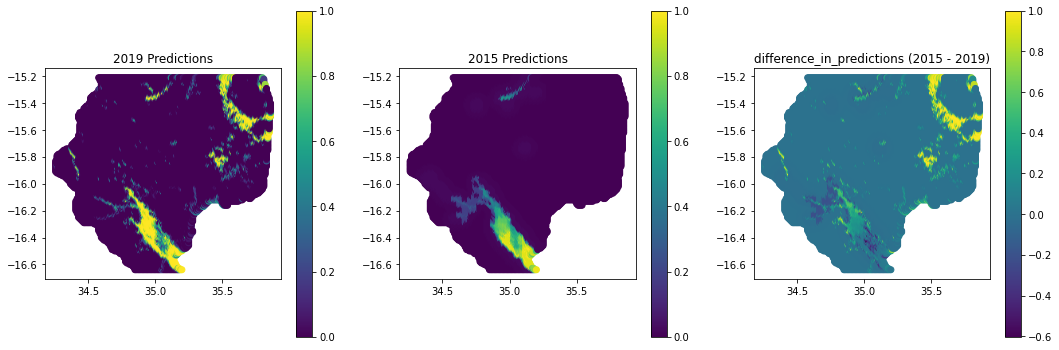

In [22]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
gdf['target_2019'] = predictions_lgb
gdf['target_2015'] = target
gdf['difference_in_predictions (2015 - 2019)'] = gdf['target_2015'] - gdf['target_2019']
gdf.plot(column = 'target_2015', figsize=(6, 6), legend=True, ax = axes[0])
gdf.plot(column = 'target_2019', figsize=(6, 6), legend=True, ax = axes[1])
gdf.plot(column = 'difference_in_predictions (2015 - 2019)', legend=True, ax = axes[2])
_ = axes[0].set_title('2019 Predictions')
_ = axes[1].set_title('2015 Predictions')
_ = axes[2].set_title('difference_in_predictions (2015 - 2019)')